In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cmath import sqrt
from matplotlib import rc
import math
import pathlib
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline
import os
import re
import shutil

from scipy.interpolate import interp1d
import matplotlib.patches as mpatches
from matplotlib.colors import colorConverter as cc
import matplotlib.font_manager

# plt.rcParams["font.family"] = ["Nunito Sans"]
plt.rcParams["font.size"] = 24
plt.rcParams["figure.figsize"] = [16,10]


plt.rc('text', usetex=True)
plt.rc('font', family='serif')


In [2]:
class LegendObject(object):
    def __init__(self, facecolor='red', edgecolor='white', dashed=False):
        self.facecolor = facecolor
        self.edgecolor = edgecolor
        self.dashed = dashed
 
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mpatches.Rectangle(
            # create a rectangle that is filled with color
            [x0, y0+height/4], width, height/2, facecolor=self.facecolor,
            # and whose edges are the faded color
            edgecolor=self.edgecolor, lw=4)
        handlebox.add_artist(patch)
 
        # if we're creating the legend for a dashed line,
        # manually add the dash in to our rectangle
        if self.dashed == "--":
            patch1 = mpatches.Rectangle(
                [x0 + 2*width/5, y0+height/4], width/5, height/2, facecolor=self.edgecolor,
                transform=handlebox.get_transform())
            handlebox.add_artist(patch1)
        elif self.dashed == "-.":
            patch1 = mpatches.Rectangle(
                [x0 + width/4, y0+height/5], width/8, height/2, facecolor=self.edgecolor,
                transform=handlebox.get_transform())
            handlebox.add_artist(patch1)
            patch1 = mpatches.Rectangle(
                [x0 + 2.*width/4, y0+height/5], width/8, height/2, facecolor=self.edgecolor,
                transform=handlebox.get_transform())
            handlebox.add_artist(patch1)

        return patch
    
def confidence_plots_costs(time, data, labels, min, max, color, mode="local"):

    confidence_max = [None] * len(data)
    confidence_min = [None] * len(data)
    
    sm_data = data
    smoothed_time = time[:len(data)]



    plt.plot(smoothed_time, sm_data, label=labels, color=color)

    data = np.array(data)
    min = np.array(min)
    max = np.array(max)

    if mode == "local":
        for i in range(len(data)):
            confidence_min[i] = data[i] - min[i]
            confidence_max[i] = data[i] + max[i]
    else:
        for i in range(len(data)):

            confidence_min[i] = min[i]
            confidence_max[i] = max[i]

    sm_con_min = confidence_min
    sm_con_max = confidence_max

    plt.fill_between(smoothed_time, sm_con_min, sm_con_max, color=color, alpha=0.1)

def confidence_create(data, mode="avg"):
    confidence_min = []
    confidence_max = []
    average_list = []
    average = 0
    number_of_tests = len(data)
    temp = []
    
    if mode == "median":
        for i in range(len(data[0])):
            temp = []
            for j in range(number_of_tests):
                temp.append(data[j][i])

            average_list.append(np.median(temp))
            sum_min = 0
            sum_max = 0
            n_min = 0
            n_max = 0

            for j in range(number_of_tests):
                if data[j][i] < average_list[-1]:
                    n_min += 1
                    sum_min = sum_min + (average_list[-1] - data[j][i])**2
                elif data[j][i] > average_list[-1]:
                    n_max += 1
                    sum_max = sum_max + (average_list[-1] - data[j][i])**2
                else: 
                    n_min += 1
                    n_max += 1

            gamma_min = sqrt(sum_min/n_min)
            gamma_max = sqrt(sum_max/n_max)

            confidence_max.append(1.96*gamma_max/sqrt(n_max))
            confidence_min.append(3.*gamma_min/sqrt(n_min))
    else:
        for i in range(len(data[0])):
                local_min = data[0][i]
                local_max = data[0][i]
                for j in range(number_of_tests):

                    average += data[j][i]
                    temp.append(data[j][i])
                    if local_min >= data[j][i]:
                        local_min = data[j][i]

                    if local_max <= data[j][i]:
                        local_max = data[j][i]

                average_list.append(average/number_of_tests) 
                sum_min = 0
                sum_max = 0
                n_min = 0
                n_max = 0

                for j in range(number_of_tests):
                    if data[j][i] < average_list[-1]:
                        n_min += 1
                        sum_min = sum_min + (average_list[-1] - data[j][i])**2
                    elif data[j][i] > average_list[-1]:
                        n_max += 1
                        sum_max = sum_max + (average_list[-1] - data[j][i])**2
                    else: 
                        n_min += 1
                        n_max += 1

                gamma_min = sqrt(sum_min/n_min)
                gamma_max = sqrt(sum_max/n_max)
                confidence_min.append(0.99*gamma_min/sqrt(n_min))
                confidence_max.append(0.99*gamma_max/sqrt(n_max))
                average = 0

    return confidence_max, average_list, confidence_min

def extract_smallest_values(arr, num=5):

    sorted_arrays = sorted(arr, key=lambda x: x[-1])
    sorted_arrays = sorted_arrays[:num]

    return sorted_arrays

def rename_subfolders(folder_path):
    folders = os.listdir(folder_path)
    
    # Проходимся по каждой папке
    for folder in folders:
        if "_seed_" in folder:
            parts = folder.split("_")
            seed_index = [i for i, part in enumerate(parts) if part == "seed"]
            if seed_index:
                seed_index = seed_index[0] + 1
                seed_number = int(parts[seed_index])
                new_folder_name = folder.replace("_seed_" + str(seed_number) + "_", "_seed_" + str(seed_number).zfill(2) + "_")
                old_path = os.path.join(folder_path, folder)
                new_path = os.path.join(folder_path, new_folder_name)
                os.rename(old_path, new_path)

            else:
                pass

def rename_csv_files(folder_path):
    print(os.walk(folder_path))
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith('.csv'):
                new_filename = filename[-9:]
                old_filepath = os.path.join(root, filename)
                new_filepath = os.path.join(root, new_filename)
                
                os.rename(old_filepath, new_filepath)
                
            elif filename.endswith('.svg'):
                new_filename = filename[-13:]
                old_filepath = os.path.join(root, filename)
                new_filepath = os.path.join(root, new_filename)
                
                os.rename(old_filepath, new_filepath)

def smooth_curve(x, y, degree):

    x = np.linspace(0, 15, 15)

    new_x = np.linspace(x.min(), x.max(), 100)


    coeffs = np.polyfit(x, y, degree)
    smoothed_y = np.polyval(coeffs, new_x)


    return smoothed_y

def exponential_smoothing(data, alpha, t1):

    x_stretched = np.linspace(t1[0], t1[1], t1[2])

    f = interp1d(np.linspace(t1[0], t1[1], len(data)), data, kind='cubic')
    y_stretched = f(x_stretched)

    smoothed_data = np.zeros_like(y_stretched)
    smoothed_data[0] = y_stretched[0]
    for t in range(1, len(y_stretched)):
        smoothed_data[t] = alpha * y_stretched[t] + (1 - alpha) * smoothed_data[t-1]
    
    return smoothed_data

def find_bests_sarsam_runs(ctrl_mode="SARSM"):
    accum_list = []
    temp = []

    seeds_list = os.listdir('{}/simdata/{}'.format(os.getcwd(),ctrl_mode))
    seeds_list.sort()
    for i,seed in enumerate(seeds_list):
        for run in range(15):

            if run < 9:
                data = pd.read_csv('{}/simdata/{}/{}/run0{}.csv'.format(os.getcwd(), ctrl_mode,seed, run+1), skiprows=15, usecols=[0,1,2,5]) 
            else:
                data = pd.read_csv('{}/simdata/{}/{}/run{}.csv'.format(os.getcwd(), ctrl_mode,seed, run+1), skiprows=15, usecols=[0,1,2,5])

            x_temp = list(data['x [m]'])[-1]
            y_temp = list(data['y [m]'])[-1]

            if np.linalg.norm([x_temp, y_temp]) > 0.2:
                continue
            else:
                for j in range(15):
                    if j < 9:
                        data = pd.read_csv('{}/simdata/{}/{}/run0{}.csv'.format(os.getcwd(), ctrl_mode,seed, j+1), skiprows=15, usecols=[0,1,2,5]) 
                    else:
                        data = pd.read_csv('{}/simdata/{}/{}/run{}.csv'.format(os.getcwd(), ctrl_mode,seed, j+1), skiprows=15, usecols=[0,1,2,5])                

                    temp.append(list(data['accum_obj'])[-1])
                accum_list.append(temp)
                temp = []
    return accum_list

def find_best_traj_seed(ctrl_mode, num=1):

    temp_list=[]
    data_list = []

    seeds_list = os.listdir('{}/simdata/{}'.format(os.getcwd(),ctrl_mode))
    seeds_list.sort()
    for i,seed in enumerate(seeds_list):
        count_of_tests = os.listdir('{}/simdata/{}/{}/'.format(os.getcwd(),ctrl_mode,seed))
        count_of_tests = [file for file in count_of_tests if file.endswith('.csv')]
        number_of_tests = len(count_of_tests)
        for j in range(number_of_tests):
            if j < 9:
                data = pd.read_csv('{}/simdata/{}/{}/run0{}.csv'.format(os.getcwd(), ctrl_mode,seed, j+1), skiprows=15, usecols=[1,2,5]) 
            else:
                data = pd.read_csv('{}/simdata/{}/{}/run{}.csv'.format(os.getcwd(), ctrl_mode,seed, j+1), skiprows=15, usecols=[1,2,5])

            x = data['x [m]']
            y = data['y [m]']
            accum = list(data['accum_obj'])[-1]
            temp_list.append([x, y, accum, seed, j+1])
    
        temp_list = sorted(temp_list, key=lambda x: x[2])
        temp = temp_list[:1][0]
        data_list.append(temp)
        temp = []
        temp_list = []

    data_list = sorted(data_list, key=lambda x: x[2])
    # for i in range(len(data_list[:num])):
    #     print('{}/simdata/{}/{}/run0{}.csv'.format(os.getcwd(), ctrl_mode, data_list[i][3], data_list[i][4]))
    return data_list[:num]

def padding(arr):

    output = []
    for i in range(len(arr)):
        temp = arr[i]

        min_index = temp.index(min(temp))

        for i in range(min_index + 1, len(temp)):
            temp[i] = min(temp)
        output.append(temp)
        temp=[]
    return output

def find_best_learning_curve(ctrl_mode, num=1):

    temp_list=[]
    data_list = []

    seeds_list = os.listdir('{}/simdata/{}'.format(os.getcwd(),ctrl_mode))
    seeds_list.sort()
    for i,seed in enumerate(seeds_list):
        count_of_tests = os.listdir('{}/simdata/{}/{}/'.format(os.getcwd(),ctrl_mode,seed))
        count_of_tests = [file for file in count_of_tests if file.endswith('.csv')]
        number_of_tests = len(count_of_tests)
        for j in range(number_of_tests):
            if j < 9:
                data = pd.read_csv('{}/simdata/{}/{}/run0{}.csv'.format(os.getcwd(), ctrl_mode,seed, j+1), skiprows=15, usecols=[1,2,4,5]) 
            else:
                data = pd.read_csv('{}/simdata/{}/{}/run{}.csv'.format(os.getcwd(), ctrl_mode,seed, j+1), skiprows=15, usecols=[1,2,4,5])

            x = data['x [m]']
            y = data['y [m]']

            x_temp = list(data['x [m]'])[-1]
            y_temp = list(data['y [m]'])[-1]

            if np.linalg.norm([x_temp, y_temp]) > 0.2:
                coef = 600
            else:
                coef = 0
            best_accum = list(data['accum_obj'])[-1]+coef
            accum_obj = list(data['accum_obj'])
            for i in range(1, len(accum_obj)):
                accum_obj[i] += coef

            temp_list.append([x, y, best_accum, accum_obj, seed, j+1])
    
        temp_list = sorted(temp_list, key=lambda x: x[2])
        temp = temp_list[:1][0]
        data_list.append(temp)
        temp = []
        temp_list = []

    data_list = sorted(data_list, key=lambda x: x[2])
    # for i in range(len(data_list[:num])):
    #     print('{}/simdata/{}/{}/run0{}.csv'.format(os.getcwd(), ctrl_mode, data_list[i][4], data_list[i][5]))
    #     print(data_list[i][3])
    return data_list[:num]

def adjust(data):
    max_len =1
    temp = []
    output = []

    for i in range(len(data)):
        list_len = len(data[i])

        if max_len < list_len:
            max_len=list_len           

    for i in range(len(data)):
        list_len = len(data[i])
        output.append(data[i])

        for j in range(int(list_len)-1, int(max_len)-1):
            output[i].append(output[i][-1])


    return output

def penalty(observation, obstacle_positions, sigma, penalty_factor):
    mu_x = obstacle_positions[0]
    sigma_x = sigma

    mu_y = obstacle_positions[1]
    sigma_y = sigma
    rho = 0
    x = observation[0]
    y = observation[1]
    z = ((x - mu_x) ** 2) / (sigma_x ** 2) + ((y - mu_y) ** 2) / (sigma_y ** 2) - (2 * rho * (x - mu_x) * (y - mu_y)) / (sigma_x * sigma_y)
    denom = 2 * np.pi * sigma_x * sigma_y * np.sqrt(1 - rho ** 2)
    return np.exp(-z / (2 * (1 - rho ** 2))) / denom * penalty_factor

def traj_prepare(ctrl_mode, seed, Nactor, run):

    data = pd.read_csv('{}/simdata/{}/Init_angle_1.57_seed_{}_Nactor_{}/run{}.csv'.format(os.getcwd(), ctrl_mode, seed, Nactor, run), skiprows=15, usecols=[0,1,2])

    x = data['x [m]']
    y = data['y [m]']
    return (x, y)

def traj_prepare_2(ctrl_mode, seed, run):
    if run < 9:
        data = pd.read_csv('{}/simdata/{}/{}/run0{}.csv'.format(os.getcwd(), ctrl_mode,seed, run+1), skiprows=15, usecols=[0,1,2]) 
    else:
        data = pd.read_csv('{}/simdata/{}/{}/run{}.csv'.format(os.getcwd(), ctrl_mode,seed, run+1), skiprows=15, usecols=[0,1,2])

    x_temp = list(data['x [m]'])[-1]
    y_temp = list(data['y [m]'])[-1]

    x = data['x [m]']
    y = data['y [m]']

    if np.linalg.norm([x_temp, y_temp]) > 0.2:
        return (None, None)
    else:
        # print('{}/simdata/{}/{}/run0{}.csv'.format(os.getcwd(), ctrl_mode,seed, run+1))
        return (x, y)

def find_best_traj_run(ctrl_mode, num=1):

    data_list = []

    seeds_list = os.listdir('{}/simdata/{}'.format(os.getcwd(),ctrl_mode))
    seeds_list.sort()
    for i,seed in enumerate(seeds_list):
        count_of_tests = os.listdir('{}/simdata/{}/{}/'.format(os.getcwd(),ctrl_mode,seed))
        count_of_tests = [file for file in count_of_tests if file.endswith('.csv')]
        number_of_tests = len(count_of_tests)
        for j in range(number_of_tests):
            if j < 9:
                data = pd.read_csv('{}/simdata/{}/{}/run0{}.csv'.format(os.getcwd(), ctrl_mode,seed, j+1), skiprows=15, usecols=[1,2,5]) 
            else:
                data = pd.read_csv('{}/simdata/{}/{}/run{}.csv'.format(os.getcwd(), ctrl_mode,seed, j+1), skiprows=15, usecols=[1,2,5])

            x = data['x [m]']
            y = data['y [m]']
            accum = list(data['accum_obj'])[-1]
            data_list.append([x, y, accum, seed, j+1])

    sorted_arrays = sorted(data_list, key=lambda x: x[2])
    sorted_arrays = sorted_arrays[:num]
    return sorted_arrays

def data_preparing(ctrl_mode,seed):
          
    number_of_tests = 0
    confidence_min = []
    confidence_max = []
    raw_data_list = []
    list_of_time = []
    average_list = []
    list_len = []
    costs = []
    gamma = 0
    temp = []
    average = 0
    max_len = 0
    accum_obj = []
    best_accum = 1e10
    best_list = []

    path = pathlib.Path("{}/simdata/{}/{}/".format(os.getcwd(),ctrl_mode, seed))

    count_of_tests = os.listdir('{}/simdata/{}/{}'.format(os.getcwd(),ctrl_mode,seed))
    count_of_tests = [file for file in count_of_tests if file.endswith('.csv')]
    number_of_tests = len(count_of_tests)
    ################################################################################################################
    # print(number_of_tests)

    for i in range(number_of_tests):
        if i < 9:
            raw_data = pd.read_csv('{}/simdata/{}/{}/run0{}.csv'.format(os.getcwd(), ctrl_mode,seed, i+1), skiprows=15, usecols=[0,1,2,3,4,5,6,7]) 
        else:
            raw_data = pd.read_csv('{}/simdata/{}/{}/run{}.csv'.format(os.getcwd(), ctrl_mode,seed, i+1), skiprows=15, usecols=[0,1,2,3,4,5,6,7])

        x_temp = list(raw_data['x [m]'])[-1]
        y_temp = list(raw_data['y [m]'])[-1]

        if np.linalg.norm([x_temp, y_temp]) > 0.2:
            coef = 600
        else:
            coef = 0

        temp = list(raw_data['accum_obj'])
        accum_obj.append(temp[-1] + coef)
        raw_data_list.append(raw_data)

        for j in range(1, len(raw_data_list[i]['accum_obj'])):
            raw_data_list[i]['accum_obj'][j] += coef

        # raw_data_list[i]['accum_obj'] = raw_data_list[i]['accum_obj'] + coef

        list_len.append(len(list(raw_data_list[i]['t [s]'])))

        if max_len < list_len[i]:
            max_len=list_len[i]
            list_of_time=raw_data_list[i]['t [s]']

        if temp[-1] < best_accum:
            best_accum = temp[-1]
            best_list = list(raw_data_list[i]['accum_obj'])

            
        
    for i in range(number_of_tests):
        for j in range(len(best_list)-1, max_len-1):
            best_list.append(best_list[-1])
            
        costs.append(list(raw_data_list[i]['accum_obj']))

        for j in range(list_len[i]-1, max_len-1):
            costs[i].append(costs[i][list_len[i]-1])

   
    if ctrl_mode in ["N_CTRL", "MPC"]:
        accum_obj = np.min(accum_obj)
    else:
        for i in range(max_len):
            local_min = costs[0][i]
            local_max = costs[0][i]
            for j in range(number_of_tests):
                average += costs[j][i]

                if local_min >= costs[j][i]:
                    local_min = costs[j][i]

                if local_max <= costs[j][i]:
                    local_max = costs[j][i]

            average_list.append(average/number_of_tests) # 1)

            sum_min = 0
            sum_max = 0
            n_min = 0
            n_max = 0

            for j in range(number_of_tests):
                if costs[j][i] < average_list[-1]:
                    n_min += 1
                    sum_min = sum_min + (average_list[-1] - costs[j][i])**2
                elif costs[j][i] > average_list[-1]:
                    n_max += 1
                    sum_max = sum_max + (average_list[-1] - costs[j][i])**2

                else:
                    n_min += 1
                    sum_min = sum_min + (average_list[-1] - costs[j][i])**2
                    n_max += 1
                    sum_max = sum_max + (average_list[-1] - costs[j][i])**2    
                
            gamma_min = sqrt(sum_min/n_min)
            gamma_max = sqrt(sum_max/n_max)

            confidence_min.append(0.99*gamma_min/sqrt(n_min))
            confidence_max.append(0.99*gamma_max/sqrt(n_max))
            
            average = 0


    return (list(list_of_time), list(average_list), list(confidence_min), list(confidence_max), number_of_tests, list(raw_data_list), accum_obj, list(best_list))

In [3]:
rename_csv_files('{}/simdata/'.format(os.getcwd()))
ctrl_mode = os.listdir('{}/simdata/'.format(os.getcwd()))

for i,ctrl in enumerate(ctrl_mode):
    rename_subfolders('{}/simdata/{}/'.format(os.getcwd(), ctrl))

<generator object _walk at 0x7f7ce2db76e0>


In [4]:
def replace_elements(arr):
    if not arr:
        return []
    min_val = min(arr)
    min_index = arr.index(min_val)
    for i in range(min_index + 1, len(arr)):
        arr[i] = min_val

    return arr

seed_values = []

print(ctrl_mode)

list_of_key = ["number_of_tests", "confidence_min",
            "confidence_max", "raw_data_list",
            "list_of_time", "average_list", "accum", "best_list"]

dict_ctrl = {}

for i, ctrl in enumerate(ctrl_mode):
    seeds_list = os.listdir('{}/simdata/{}'.format(os.getcwd(),ctrl))
    dict_ctrl['{}'.format(ctrl)] = {}
    for j,seed in enumerate(seeds_list):
        dict_ctrl['{}'.format(ctrl)]['{}'.format(seed)] = {}

        for k,key in enumerate(list_of_key):
            dict_ctrl['{}'.format(ctrl)]['{}'.format(seed)]['{}'.format(key)] = []

for i, ctrl in enumerate(ctrl_mode):
    seeds_list = os.listdir('{}/simdata/{}'.format(os.getcwd(),ctrl))
    seeds_list.sort()
    for j,seed in enumerate(seeds_list):
        t, avg, min_c, max_c, tests, raw_data, accum, best_list = data_preparing(ctrl,seed)
        dict_ctrl['{}'.format(ctrl)]['{}'.format(seed)]['{}'.format(list_of_key[0])] = t.copy()
        dict_ctrl['{}'.format(ctrl)]['{}'.format(seed)]['{}'.format(list_of_key[1])] = min_c
        dict_ctrl['{}'.format(ctrl)]['{}'.format(seed)]['{}'.format(list_of_key[2])] = max_c
        dict_ctrl['{}'.format(ctrl)]['{}'.format(seed)]['{}'.format(list_of_key[3])] = accum.copy()
        dict_ctrl['{}'.format(ctrl)]['{}'.format(seed)]['{}'.format(list_of_key[4])] = tests
        dict_ctrl['{}'.format(ctrl)]['{}'.format(seed)]['{}'.format(list_of_key[5])] = avg.copy()
        dict_ctrl['{}'.format(ctrl)]['{}'.format(seed)]['{}'.format(list_of_key[6])] = accum.copy()
        dict_ctrl['{}'.format(ctrl)]['{}'.format(seed)]['{}'.format(list_of_key[7])] = best_list.copy()

['N_CTRL', 'MPC', 'CALF', 'SARSM']


In [5]:
number_of_tests = []
confidence_min = []
confidence_max = []
raw_data_list = []
list_of_time = []
average_list = []

for i,ctrl in enumerate(ctrl_mode):
        if ctrl != "N_CTRL" and ctrl != "MPC":
            seeds_list = os.listdir('{}/simdata/{}'.format(os.getcwd(),ctrl))

            for j,seed in enumerate(seeds_list):
                local_seed = os.listdir('{}/simdata/{}'.format(os.getcwd(),"N_CTRL"))
                accum_n_ctrl = dict_ctrl['{}'.format("N_CTRL")]['{}'.format(local_seed[0])]['{}'.format(list_of_key[6])]
                local_seed = os.listdir('{}/simdata/{}'.format(os.getcwd(),"MPC"))
                accum_mpc = dict_ctrl['{}'.format("MPC")]['{}'.format(local_seed[0])]['{}'.format(list_of_key[6])]

                accum = dict_ctrl['{}'.format(ctrl)]['{}'.format(seed)]['{}'.format(list_of_key[6])].copy()

                accum = replace_elements(accum)

###############################################################################################################################
                accum_padd = dict_ctrl['{}'.format(ctrl)]['{}'.format(seed)]['{}'.format(list_of_key[3])]
                accum_padd = replace_elements(accum_padd)
###############################################################################################################################
                plt.plot(range(len(accum)), accum)
                plt.plot(range(len(accum)), [accum_mpc]*len(accum), linestyle='--', color='green')
                plt.plot(range(len(accum)), [accum_n_ctrl]*len(accum), linestyle='--', color='red')
                plt.grid()


                plt.rcParams["font.size"] = 24
                plt.rcParams["figure.figsize"] = [16,10]

                plt.xlabel('Run number')
                plt.ylabel('Accumulated cost')
                plt.title('Угол {}'.format(seed))

                # os.makedirs("{}/plots/{}/padd/".format(os.getcwd(),ctrl), exist_ok=True)
                # plt.savefig("{}/plots/{}/padd/{}.svg".format(os.getcwd(),ctrl,seed))
                # plt.show()
                plt.clf()


<Figure size 1600x1000 with 0 Axes>

/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:5346: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:5347: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:5350: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice
/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:5352: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N+2:, 1] = dep2slice[::-1]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


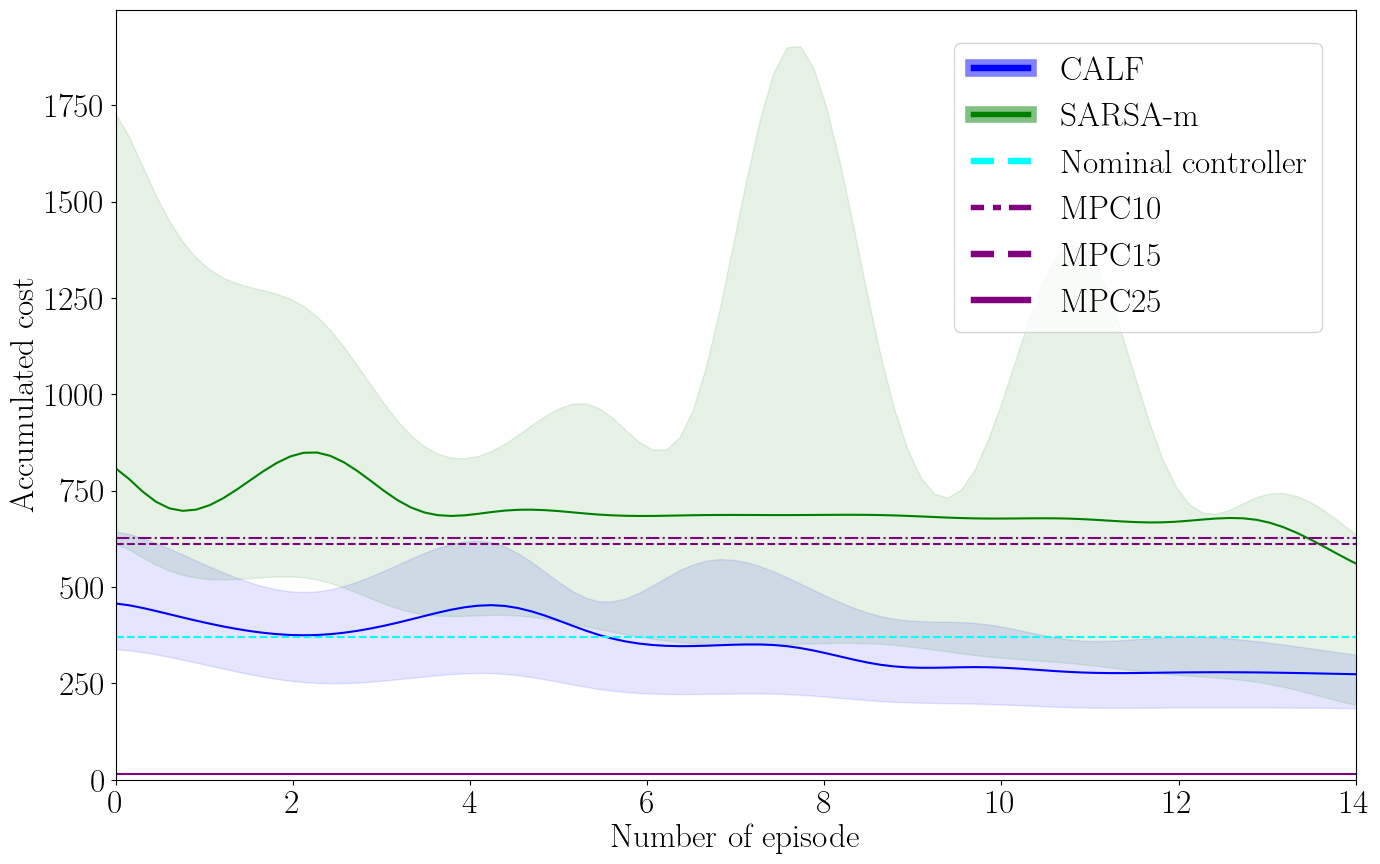

In [12]:
t1 = [0, 15, 100]
new_x = np.linspace(t1[0], t1[1], t1[2])
deg = 9
alpha = 0.5

r_costs_calf = []
r_costs_sarsm = []
r_costs_n_ctrl = []

for i, ctrl in enumerate(ctrl_mode):
    seeds_list = os.listdir('{}/simdata/{}'.format(os.getcwd(),ctrl))
    seeds_list.sort()
    for j,seed in enumerate(seeds_list):
        if ctrl == "CALF":
            r_costs_calf.append(dict_ctrl['{}'.format(ctrl)]['{}'.format(seed)]['{}'.format(list_of_key[3])])
        elif ctrl == "SARSM":
            r_costs_sarsm.append(dict_ctrl['{}'.format(ctrl)]['{}'.format(seed)]['{}'.format(list_of_key[3])])
        elif ctrl == "N_CTRL":
            r_costs_n_ctrl.append(dict_ctrl['{}'.format(ctrl)]['{}'.format(seed)]['{}'.format(list_of_key[3])])
        
r_costs_sarsm = extract_smallest_values(r_costs_sarsm,25)
r_costs_calf = extract_smallest_values(r_costs_calf,len(r_costs_sarsm))


confidence_max, average_list, confidence_min = confidence_create(r_costs_calf, "median")

confidence_max = exponential_smoothing(confidence_max, alpha, t1)
confidence_min = exponential_smoothing(confidence_min, alpha, t1)
average_list = exponential_smoothing(average_list, alpha, t1)

confidence_plots_costs(new_x, average_list, "CALF", confidence_min, confidence_max, 'blue', 'local')
#---------------------------------------------------------------------------------------------------------------------------------------

confidence_max, average_list, confidence_min = confidence_create(r_costs_sarsm, "median")

confidence_max = exponential_smoothing(confidence_max, alpha,t1)
confidence_min = exponential_smoothing(confidence_min, alpha,t1)
average_list = exponential_smoothing(average_list, alpha,t1)

confidence_plots_costs(new_x, average_list, "SARSM", confidence_min, confidence_max, 'green', 'local')
##################################################################


local_seed = os.listdir('{}/simdata/{}'.format(os.getcwd(),"N_CTRL"))
accum_n_ctrl = dict_ctrl['{}'.format("N_CTRL")]['{}'.format(local_seed[0])]['{}'.format(list_of_key[6])]
plt.plot(new_x, [accum_n_ctrl]*len(new_x), linestyle='--', color='cyan', label="Nominal controller")

local_seed = os.listdir('{}/simdata/{}'.format(os.getcwd(),"MPC"))
local_seed.sort()
accum_mpc = dict_ctrl['{}'.format("MPC")]['{}'.format(local_seed[0])]['{}'.format(list_of_key[6])]
plt.plot(new_x, [accum_mpc+5]*len(new_x), linestyle='-.', color='purple', label="MPC10")
accum_mpc = dict_ctrl['{}'.format("MPC")]['{}'.format(local_seed[1])]['{}'.format(list_of_key[6])]
plt.plot(new_x, [accum_mpc-5]*len(new_x), linestyle='--', color='purple', label="MPC15")
accum_mpc = dict_ctrl['{}'.format("MPC")]['{}'.format(local_seed[3])]['{}'.format(list_of_key[6])]
plt.plot(new_x, [accum_mpc]*len(new_x), linestyle='-', color='purple', label="MPC25")

bg = np.array([1, 1, 1]) 
colors = ['blue', 'green', 'cyan', "purple"]

colors_faded = [(np.array(cc.to_rgb(color)) + bg) / 2.0 for color in colors]
 
plt.legend()
plt.legend([0, 1, 2, 3, 4, 5], ['CALF', 'SARSA-m', 'Nominal controller', "MPC10", "MPC15", "MPC25"], borderaxespad=1,
           handler_map={
               0: LegendObject(colors[0], colors_faded[0]),
               1: LegendObject(colors[1], colors_faded[1]),
               2: LegendObject(colors[2], dashed="--"),
               3: LegendObject(colors[3], dashed="-."),
               4: LegendObject(colors[3], dashed="--"),
               5: LegendObject(colors[3]),})

colors_faded = [(np.array(cc.to_rgb(color)) + bg) / 2.0 for color in colors]
 
plt.xlabel('Number of episode')
plt.ylabel('Accumulated cost')

plt.ylim(0)
plt.xlim(0,14)
plt.savefig("{}/plots/confidence.pdf".format(os.getcwd()))

[0.2002449624194068, 0.4004924359834934, 0.6007770944795885, 0.8012798034323404, 1.00200391332992, 1.2007874470952136, 1.3976762507177118, 1.5929424188401826, 1.7867862079208416, 1.9793414837729009, 2.1707438020035283, 2.3610832517885894, 2.550409513914764, 2.738687861427477, 2.9258133070416643, 3.111699492514083, 3.2962763324581195, 3.4794853270889843, 3.661278772125136, 3.841634403544818, 4.020553477114641, 4.198039929718053, 4.374100900326382, 4.54874357077604, 4.721961874760559, 4.893738286003836, 5.064055343141801, 5.232895544982616, 5.400241704781349, 5.56607703201151, 5.7303852389218495, 5.89315064298573, 6.054358283630644, 6.213994047133617, 6.372044808752872, 6.528498587565814, 6.683344723137202, 6.836574067798492, 6.988179205660874, 7.138154688588881, 7.286497302919795, 7.433206352273109, 7.57828397292408, 7.721735460819487, 7.863569659589974, 8.00379926966136, 8.142441224586822, 8.27951709224532, 8.415053446047304, 8.549082198717652, 8.68164090272178, 8.812773054958951, 8.94

/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:5346: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:5347: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:5350: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice
/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:5352: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N+2:, 1] = dep2slice[::-1]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_31955/1829464323.py:153: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0)


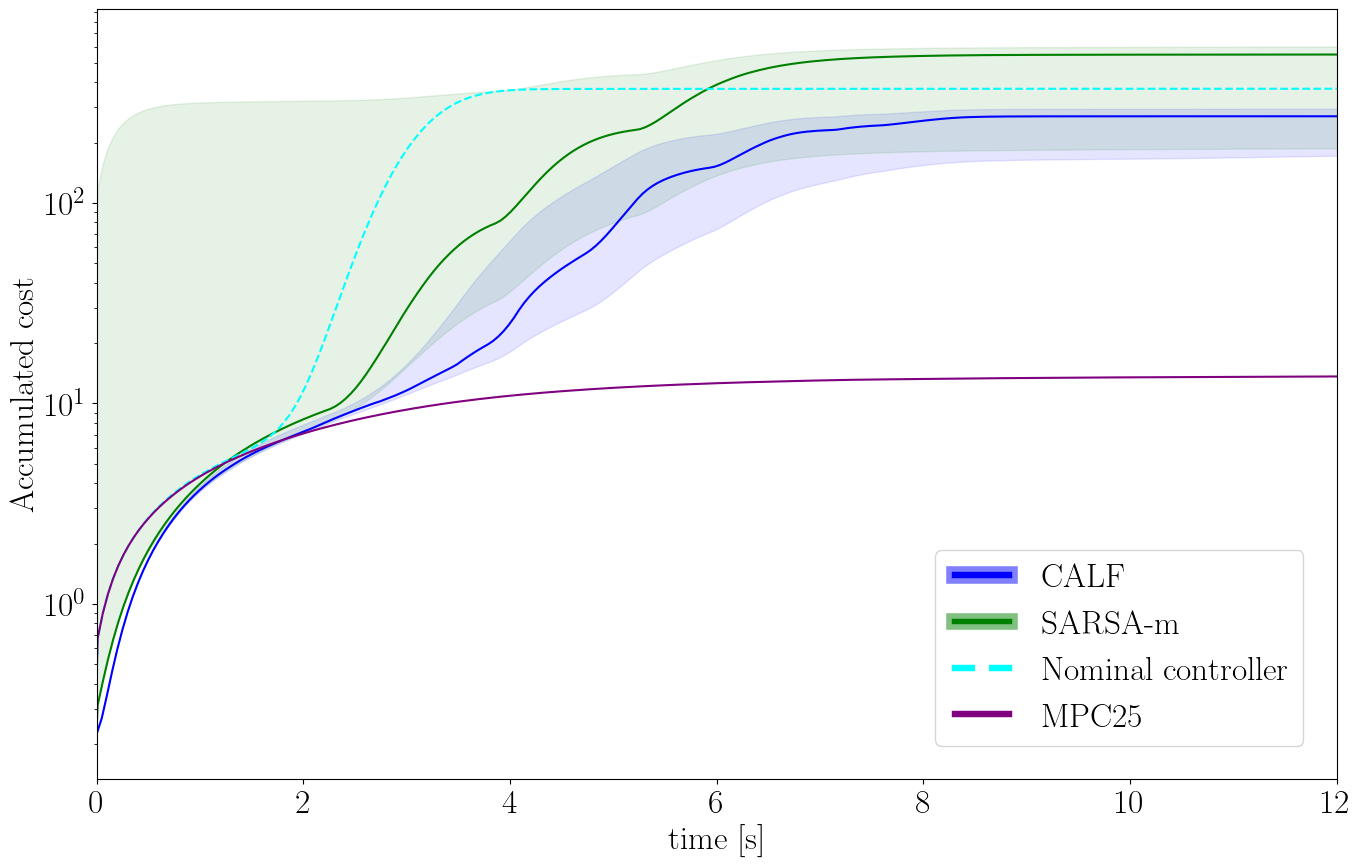

In [13]:

calf_l = find_best_learning_curve("CALF", 25)
sarsa_l = find_best_learning_curve("SARSM", 25)

calf_l = [sub_array[3] for sub_array in calf_l]
sarsa_l = [sub_array[3] for sub_array in sarsa_l]

sarsa_l = adjust(sarsa_l)
calf_l = adjust(calf_l)

t1 = [0, 30, 603]
new_x = np.linspace(t1[0], t1[1], t1[2])
alpha = 0.2

confidence_max, average_list, confidence_min = confidence_create(calf_l, "median")

confidence_max = exponential_smoothing(confidence_max, alpha, t1)
confidence_min = exponential_smoothing(confidence_min, alpha, t1)
average_list = exponential_smoothing(average_list, alpha, t1)

confidence_plots_costs(new_x, average_list, "CALF", confidence_min, confidence_max, 'blue', 'local')

#---------------------------------------------------------------------------------------------------------------------------------------

confidence_max, average_list, confidence_min = confidence_create(sarsa_l, "median")

confidence_max = exponential_smoothing(confidence_max, alpha,t1)
confidence_min = exponential_smoothing(confidence_min, alpha,t1)
average_list = exponential_smoothing(average_list, alpha,t1)

new_x = dict_ctrl['{}'.format(ctrl)]['{}'.format(seeds_list[0])]['{}'.format(list_of_key[4])]

confidence_plots_costs(t, average_list, "SARSM", confidence_min, confidence_max, 'green', 'local')
################################################################################################################

local_seed = os.listdir('{}/simdata/{}'.format(os.getcwd(),"N_CTRL"))
accum_n_ctrl = dict_ctrl['{}'.format("N_CTRL")]['{}'.format(local_seed[0])]['{}'.format(list_of_key[7])]
plt.plot(t, accum_n_ctrl, linestyle='--', color='cyan', label="Nominal controller")

local_seed = os.listdir('{}/simdata/{}'.format(os.getcwd(),"MPC"))
local_seed.sort()

# accum_mpc = dict_ctrl['{}'.format("MPC")]['{}'.format(local_seed[0])]['{}'.format(list_of_key[7])]
# accum_mpc = exponential_smoothing(accum_mpc, alpha, t1)
# plt.plot(t, np.array(accum_mpc)*1.01, linestyle='-.', color='purple', label="MPC10")

# accum_mpc = dict_ctrl['{}'.format("MPC")]['{}'.format(local_seed[1])]['{}'.format(list_of_key[7])]
# accum_mpc = exponential_smoothing(accum_mpc, alpha, t1)
# plt.plot(t, accum_mpc, linestyle='--', color='purple', label="MPC15")

accum_mpc = dict_ctrl['{}'.format("MPC")]['{}'.format(local_seed[3])]['{}'.format(list_of_key[7])]

plt.plot(t, accum_mpc, linestyle='-', color='purple', label="MPC25")

plt.legend()
################################################################################################################

bg = np.array([1, 1, 1]) 
colors = ['blue', 'green', 'cyan', "purple"]

colors_faded = [(np.array(cc.to_rgb(color)) + bg) / 2.0 for color in colors]
 
plt.legend([0, 1, 2, 3], ['CALF', 'SARSA-m', 'Nominal controller', "MPC25"], borderaxespad=1,
           handler_map={
               0: LegendObject(colors[0], colors_faded[0]),
               1: LegendObject(colors[1], colors_faded[1]),
               2: LegendObject(colors[2], dashed="--"),
               3: LegendObject(colors[3]),})
plt.xlabel('time [s]')
plt.ylabel('Accumulated cost')
plt.yscale("log")
plt.ylim(0)
plt.xlim(0,12)
plt.savefig("{}/plots/time.pdf".format(os.getcwd()))

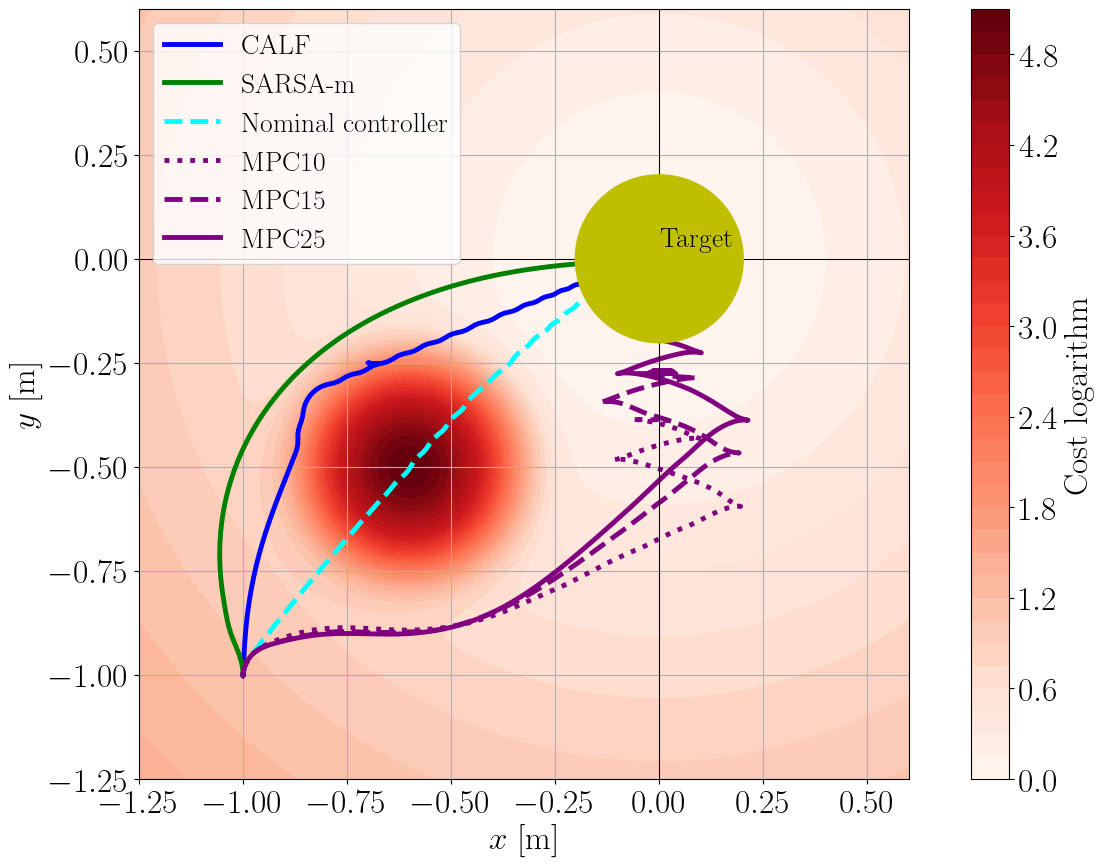

<Figure size 1600x1000 with 0 Axes>

In [14]:

mu_x = -0.6
variance_x = 0.1
mu_y = -0.5
variance_y = 0.1

x = np.linspace(-1.25, 0.6, 100)
y = np.linspace(-1.25, 0.6, 100)
X, Y = np.meshgrid(x, y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

run_obj = np.empty(X.shape)
gaus = np.empty(X.shape)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        chi = np.array([X[i, j], Y[i, j]])
        R1 = np.array([[1, 0], [0, 1]])
        run_obj[i, j] = chi @ R1 @ chi
        gaus[i,j] = penalty([X[i, j], Y[i, j]], [mu_x,mu_y], variance_x, 1e1)


circle_coord = [-0.6, -0.5, 0.1]
fig, ax = plt.subplots(figsize=(16, 10))

x_C, y_C = traj_prepare("CALF", 64, 1, "03")
x_S, y_S = traj_prepare("SARSM", 34, 1, "04")
x_N, y_N = traj_prepare("N_CTRL", "01", 1, "01")
x_Mb, y_Mb = traj_prepare("MPC", "01", 10, "01")
x_Mn, y_Mn = traj_prepare("MPC", "01", 15, "01")
x_M, y_M = traj_prepare("MPC", "01", 25, "01")

data = np.log(gaus+run_obj+1)
plt.contourf(X,Y,data, 40, cmap='Reds')
plt.colorbar(label="Cost logarithm")
plt.clim(0, 5)

CALF_footpint, = ax.plot(x_C, y_C, color="blue", label= "CALF", linewidth=3.5, linestyle='-')
SARSAM_footprint, = ax.plot(x_S, y_S, color="green", label= "SARSA-m", linewidth=3.5, linestyle='-')
N_CTRL_footprint, = ax.plot(x_N, y_N, color="cyan", label= "Nominal controller", linewidth=3.5, linestyle='--')
MPC_g_footprint, = ax.plot(x_Mb, y_Mb, color="purple", label= "MPC10", linewidth=3.5, linestyle=':')
MPC_n_footprint, = ax.plot(x_Mn, y_Mn, color="purple", label= "MPC15", linewidth=3.5, linestyle='--')
MPC_b_footprint, = ax.plot(x_M, y_M, color="purple", label= "MPC25", linewidth=3.5, linestyle='-')

ax.grid(True)
plt.xticks(np.arange(-1.25, 0.6, 0.25))
plt.yticks(np.arange(-1.25, 0.6, 0.25))
ax.axhline(0, color='black', linewidth=0.75)
ax.axvline(0, color='black', linewidth=0.75)

plt.rcParams["font.size"] = 20

cirlce_target = plt.Circle((0, 0), radius=0.2, color='y', fill=True, lw=2)
ax.add_artist(cirlce_target)
text_target_handle = ax.text(0.677, 0.7, 'Target',
                                        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes) 
cirlce_target.set_zorder(2)

ax.set_aspect("equal")

plt.xlabel('$x$ [m]')
plt.ylabel('$y$ [m]')
plt.xlim(-1.25, 0.6)  
plt.ylim(-1.25, 0.6) 

plt.legend(loc='upper left', borderaxespad=0.5)

plt.savefig("{}/plots/traj1.pdf".format(os.getcwd()), bbox_inches='tight')

plt.show()
plt.clf()

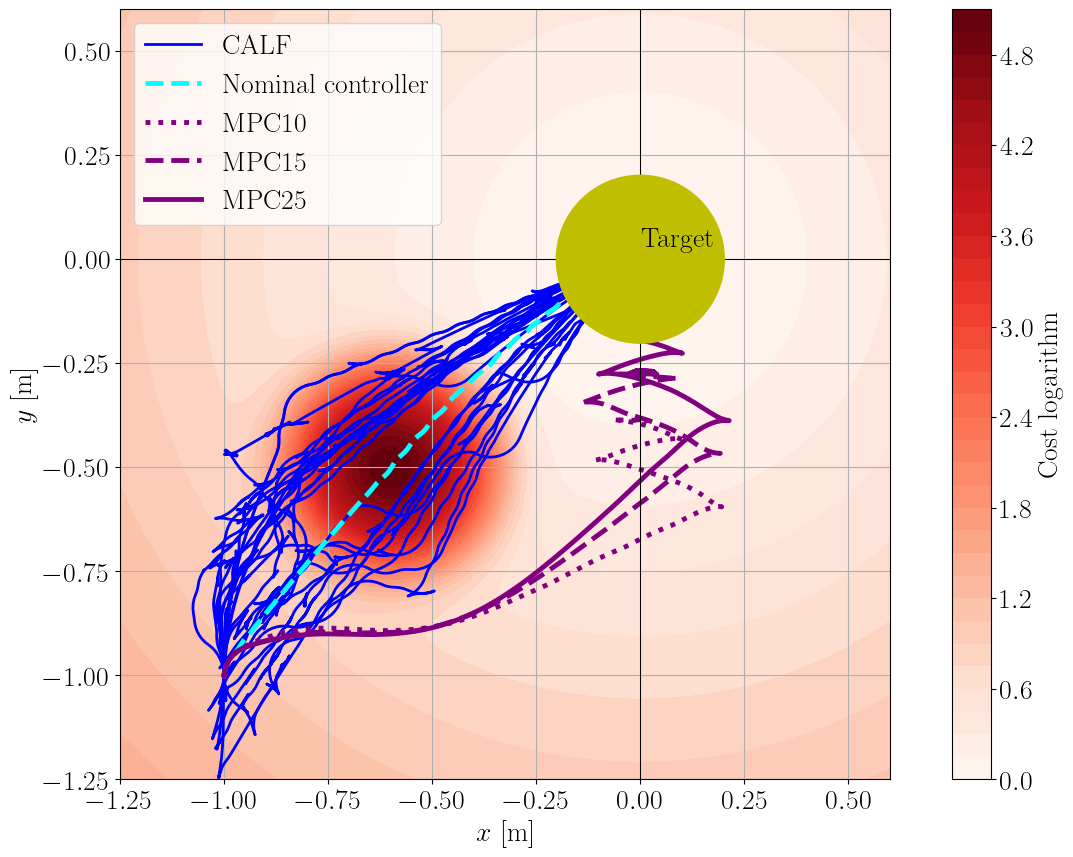

<Figure size 1600x1000 with 0 Axes>

In [15]:
fig, ax = plt.subplots(figsize=(16, 10))

C_traj = find_best_traj_seed("CALF", 25)
for i, sub in enumerate(C_traj):
    S_traj, = ax.plot(sub[0], sub[1], linewidth=2, linestyle='-', alpha=1., color='blue')

data = np.log(gaus+run_obj+1)
plt.contourf(X,Y,data, 40, cmap='Reds')
plt.colorbar(label="Cost logarithm")
plt.clim(0, 5)

CALF_footpint, = ax.plot(x_C, y_C, color="blue", label= "CALF", linewidth=2, linestyle='-')
N_CTRL_footprint, = ax.plot(x_N, y_N, color="cyan", label= "Nominal controller", linewidth=3.5, linestyle='--')
MPC_g_footprint, = ax.plot(x_Mb, y_Mb, color="purple", label= "MPC10", linewidth=3.5, linestyle=':')
MPC_n_footprint, = ax.plot(x_Mn, y_Mn, color="purple", label= "MPC15", linewidth=3.5, linestyle='--')
MPC_b_footprint, = ax.plot(x_M, y_M, color="purple", label= "MPC25", linewidth=3.5, linestyle='-')

ax.grid(True)
plt.xticks(np.arange(-1.25, 0.6, 0.25))
plt.yticks(np.arange(-1.25, 0.6, 0.25))
ax.axhline(0, color='black', linewidth=0.75)
ax.axvline(0, color='black', linewidth=0.75)

cirlce_target = plt.Circle((0, 0), radius=0.2, color='y', fill=True, lw=2)
ax.add_artist(cirlce_target)
text_target_handle = ax.text(0.677, 0.7, 'Target',
                                        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes) 
cirlce_target.set_zorder(2)

ax.set_aspect("equal")

plt.xlabel('$x$ [m]')
plt.ylabel('$y$ [m]')
plt.xlim(-1.25, 0.6)  
plt.ylim(-1.25, 0.6) 

plt.legend(loc='upper left', borderaxespad=0.5)

plt.savefig("{}/plots/traj2.pdf".format(os.getcwd()))

plt.show()
plt.clf()

25
160
0     -1.000000
1     -1.000000
2     -1.000000
3     -1.000012
4     -1.000039
         ...   
155   -0.213649
156   -0.209188
157   -0.204752
158   -0.200316
159   -0.196125
Name: x [m], Length: 160, dtype: float64


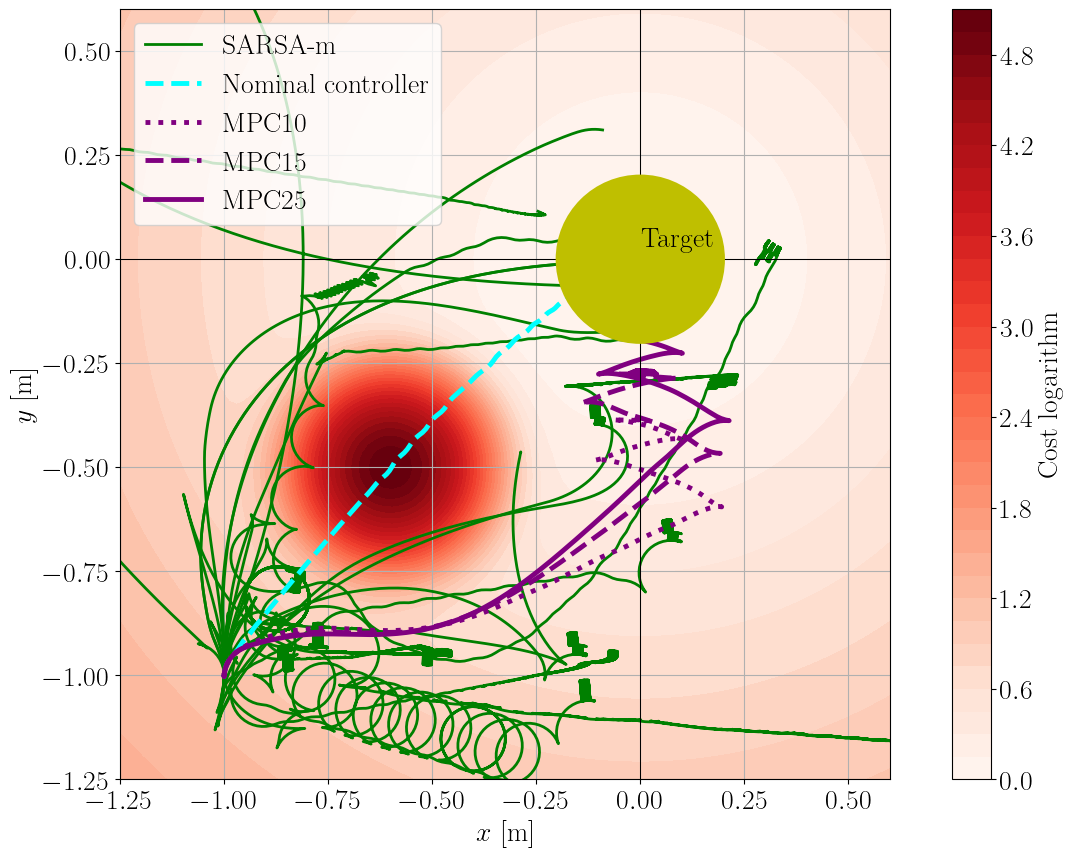

<Figure size 1600x1000 with 0 Axes>

In [16]:
fig, ax = plt.subplots(figsize=(16, 10))

S_traj = find_best_traj_seed("SARSM", 25)

for i, sub in enumerate(S_traj):
    S_traje, = ax.plot(sub[0], sub[1], linewidth=2, linestyle='-', alpha=1., color='green')

data = np.log(gaus+run_obj+1)
plt.contourf(X,Y,data, 40, cmap='Reds')
plt.colorbar(label="Cost logarithm")
plt.clim(0, 5)


SARSAM_footprint, = ax.plot(x_S, y_S, color="green", label= "SARSA-m", linewidth=2, linestyle='-')
N_CTRL_footprint, = ax.plot(x_N, y_N, color="cyan", label= "Nominal controller", linewidth=3.5, linestyle='--')
MPC_g_footprint, = ax.plot(x_Mb, y_Mb, color="purple", label= "MPC10", linewidth=3.5, linestyle=':')
MPC_n_footprint, = ax.plot(x_Mn, y_Mn, color="purple", label= "MPC15", linewidth=3.5, linestyle='--')
MPC_b_footprint, = ax.plot(x_M, y_M, color="purple", label= "MPC25", linewidth=3.5, linestyle='-')

ax.grid(True)
plt.xticks(np.arange(-1.25, 0.6, 0.25))
plt.yticks(np.arange(-1.25, 0.6, 0.25))
ax.axhline(0, color='black', linewidth=0.75)
ax.axvline(0, color='black', linewidth=0.75)

plt.rcParams["font.size"] = 20

cirlce_target = plt.Circle((0, 0), radius=0.2, color='y', fill=True, lw=2)
ax.add_artist(cirlce_target)
text_target_handle = ax.text(0.677, 0.7, 'Target',
                                        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes) 
cirlce_target.set_zorder(2)

ax.set_aspect("equal")

plt.xlabel('$x$ [m]')
plt.ylabel('$y$ [m]')
plt.xlim(-1.25, 0.6)  
plt.ylim(-1.25, 0.6) 

plt.legend(loc='upper left', borderaxespad=0.5)

plt.savefig("{}/plots/traj3.pdf".format(os.getcwd()))

plt.show()
plt.clf()